In [3]:
import numpy as np
from sklearn.metrics import r2_score
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() #pandasでyfinanceのデータを使用できるようにする
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

In [4]:
s_target = 'GOOG' #Googleのデータ取得
df = pdr.get_data_yahoo(s_target, start='2014-01-01', end=datetime.now())
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,27.782366,27.839401,27.603037,27.724083,27.724083,73129082
2014-01-03,27.770908,27.818977,27.520098,27.521841,27.521841,66917888
2014-01-06,27.721344,27.867046,27.557707,27.828691,27.828691,71037271
2014-01-07,28.019974,28.385853,27.924334,28.365179,28.365179,102486711
2014-01-08,28.543015,28.575891,28.226450,28.424210,28.424210,90036218


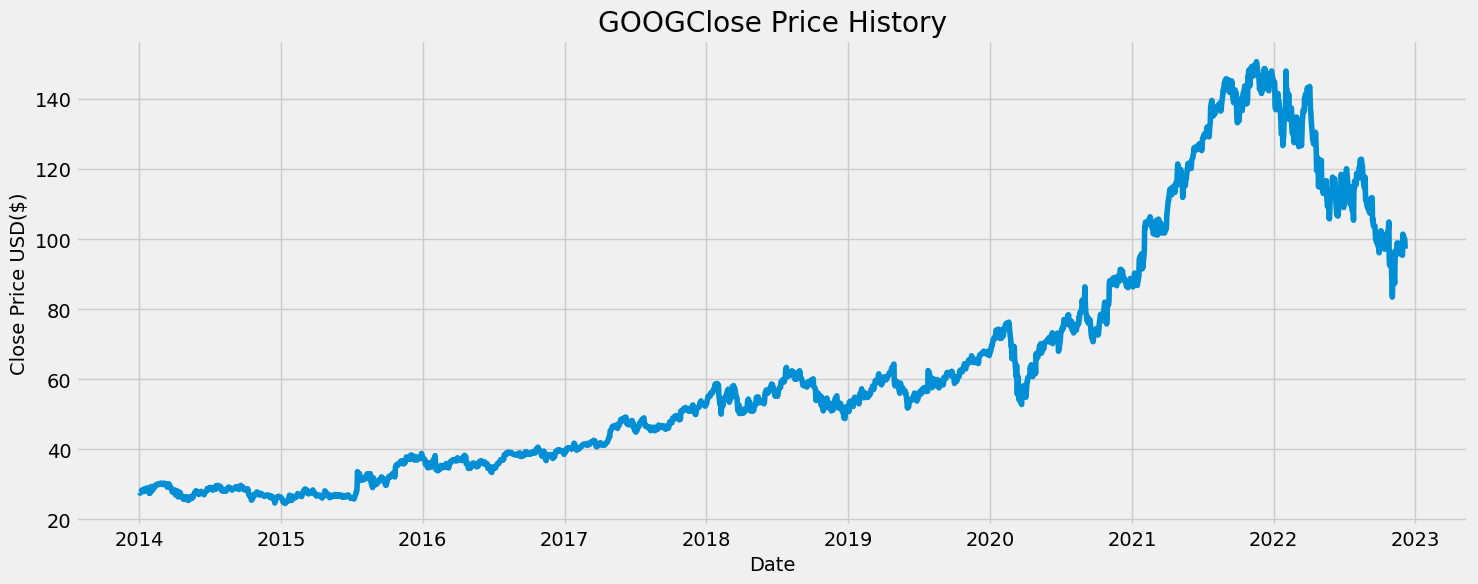

In [5]:
#株価データをグラフで確認
plt.figure(figsize=(16, 6))
plt.title(s_target + 'Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD($)', fontsize=14)
plt.show()

In [6]:
#LSTMのためのデータを準備
#Close(終値)のデータ
data = df.filter(['Close'])
dataset = data.values

#データを0~1の範囲に正規化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.02508157],
       [0.02347837],
       [0.02591081],
       ...,
       [0.60460229],
       [0.59699225],
       [0.57669873]])

In [7]:
#LSTMトレーニングデータを準備
#全体の80%をトレーニングデータとして扱う
training_data_len = int(np.ceil(len(dataset) * .8))

In [8]:
#60日分の期間をもとに予測する
window_size = 60

train_data = scaled_data[0:int(training_data_len), :]

#trainデータをx_trainとy_trainに分ける
x_train, y_train =[], []
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0]) #60日分のデータを特徴量として次の61日目を学習する
    y_train.append(train_data[i, 0])
    
#numpy arrayに変換
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [9]:
#特徴を見つけながら一部はDropoutし、忘れて強くなっていくモデル設計
#最適化アルゴリズムはadam, 損失関数にはMSEを指定
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
55/55 [==============================] - 7s 71ms/step - loss: 0.0058
Epoch 2/100
55/55 [==============================] - 3s 47ms/step - loss: 0.0011
Epoch 3/100
55/55 [==============================] - 3s 47ms/step - loss: 0.0011
Epoch 4/100
55/55 [==============================] - 3s 47ms/step - loss: 0.0012
Epoch 5/100
55/55 [==============================] - 3s 47ms/step - loss: 0.0010
Epoch 6/100
55/55 [==============================] - 3s 48ms/step - loss: 9.7719e-04
Epoch 7/100
55/55 [==============================] - 3s 46ms/step - loss: 8.7020e-04
Epoch 8/100
55/55 [==============================] - 3s 52ms/step - loss: 8.4905e-04
Epoch 9/100
55/55 [==============================] - 3s 49ms/step - loss: 7.9290e-04
Epoch 10/100
55/55 [==============================] - 3s 50ms/step - loss: 7.1545e-04
Epoch 11/100
55/55 [==============================] - 3s 47ms/step - loss: 8.4883e-04
Epoch 12/100
55/55 [==============================] - 3s 48ms/step - loss: 6.9116e-

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [11]:
# テストデータを作成
test_data = scaled_data[training_data_len - window_size: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(window_size, len(test_data)):
    x_test.append(test_data[i-window_size:i, 0])

# numpy arrayに変換
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [12]:
# 予測を実行する
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# 二乗平均平方根誤差（RMSE）: 0に近いほど良い
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(rmse)

# 決定係数(r2) : 1に近いほど良い
r2s = r2_score(y_test, predictions)
print(r2s)

15/15 [==============================] - 1s 15ms/step
5.129186618974421
0.9021974660230077


/tmp/ipykernel_5031/3339233618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


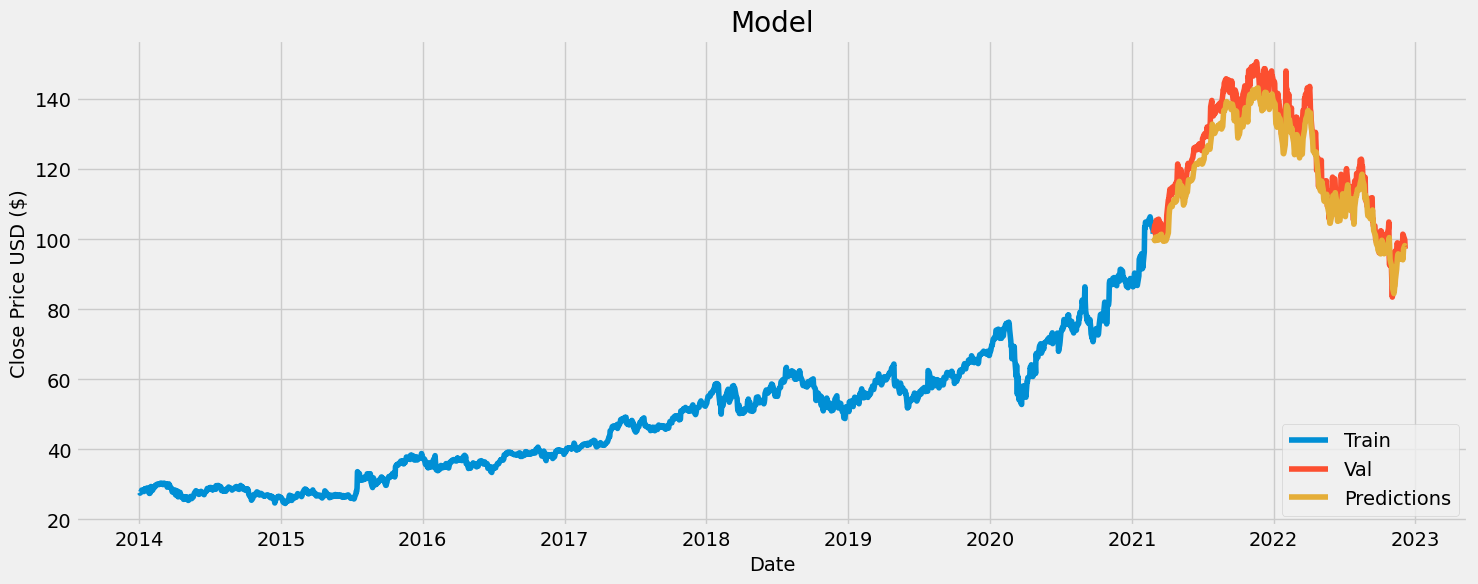

In [13]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()